In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, ifft, fftfreq

import glob
import sys
sys.path.append(r'/Users/yuhan/work/nanospheres/impulse_analysis')
from analysis_utils import load_timestreams, get_psd, highpass_filtered, bandpass_filtered, lowpass_filtered
from pulse_recon import get_pulse_amp

In [2]:
from cycler import cycler
colors=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004']
default_cycler = cycler(color=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004'])

params = {'figure.figsize': (7, 3),
          'axes.prop_cycle': default_cycler,
          'axes.titlesize': 14,
          'legend.fontsize': 12,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

In [3]:
def log_peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return np.log(amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 ))

from scipy.optimize import curve_fit
def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0, maxfev=5000)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

def fit_z_peak(ff, pp, peak_func, passband=(60000, 70000), p0=[2e8, 62500*2*np.pi, 50], plot=True):
    all_idx = np.logical_and(ff > passband[0], ff < passband[1])
    
    popt, omega_fit, p_fit = fit_peak(ff[all_idx]*2*np.pi, np.log(pp[all_idx]), peak_func, p0=p0)

    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(ff[all_idx], pp[all_idx])
        ax.plot(omega_fit/(2*np.pi), np.exp(p_fit))
        ax.set_yscale('log')

    # amp, omega0, gamma
    return popt

### Figure out if the calibration was done at one or two charges

Load data and calculate PSDs.

In [8]:
one_e_file = r'/Volumes/LaCie/20240722_plus_two_e_data/20240722_1e_5vp2p_91khz_2_1e-8mbar/20240722_1e_5vp2p_91khz_2_1e-8mbar_1.mat'
two_e_file = r'/Volumes/LaCie/20240722_plus_two_e_data/20240722_2e_5vp2p_91khz_2_1e-8mbar/20240722-0001/20240722-0001_1.mat'

dtt1, tt1, nn1 = load_timestreams(one_e_file, ['C', 'D'])
dtt2, tt2, nn2 = load_timestreams(two_e_file, ['C', 'D'])

In [145]:
ffzb1, ppzb1= get_psd(dtt1, None, nn1[1][:1000000], nperseg=10000)
ffzb2, ppzb2= get_psd(dtt2, None, nn2[1][:1000000], nperseg=10000)

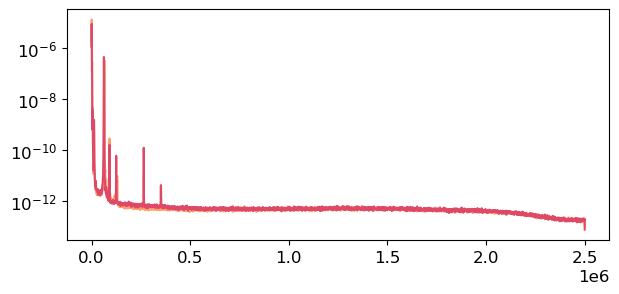

In [146]:
plt.plot(ffzb1, ppzb1)
plt.plot(ffzb2, ppzb2)
plt.yscale('log')

Fit a Lorentzian to both peaks. The fitting doesn't work very well, presumably due to frequency drifting.

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_33257/476892587.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 ))


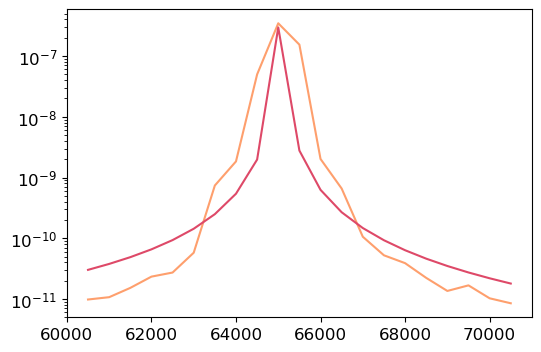

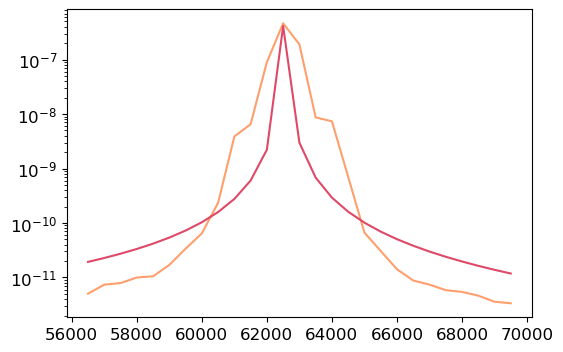

In [150]:
a1, omega01, gamma1 = fit_z_peak(ffzb1, ppzb1, log_peak_func, passband=(60000, 71000))
a2, omega02, gamma2 = fit_z_peak(ffzb2, ppzb2, log_peak_func, passband=(56000, 70000))

Assuming detection efficiency is the same, electric calibration from the backscatter signal seems to suggest that the two datasets have the same charge. But it is also clear from lock in detection that the charge has changed (and flipped sign) from 2 to 1. So for now I still believe the sphere had two charges while being calibrated.

In [151]:
def get_area_driven(ff, pp, passband=(90970, 91030), plot=True):
    idx = np.logical_and(ff > passband[0], ff < passband[1])
    area_all = np.trapz(pp[idx], ff[idx]*2*np.pi)
    v2_drive = area_all / (2 * np.pi)

    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(ff[idx], pp[idx])
    
    return v2_drive

def get_cal_factor_driven(charge, omega0, gamma, vp2p, drive_freq, v2_drive):
    rho = 2000 # kg/m^3
    r   = 166e-9 / 2
    m   = rho * (4 * np.pi / 3) * r**3

    efield_sim = 120
    omega_drive = drive_freq * 2 * np.pi
    
    f0 = charge * 1.6e-19 * efield_sim * (vp2p / 2)
    x2_drive = f0**2 / ((2 * m**2) * ( (omega0**2 - omega_drive**2)**2 + gamma**2 * omega_drive**2))

    c_cal_square = v2_drive / x2_drive
    
    return c_cal_square

1.5189227548745212


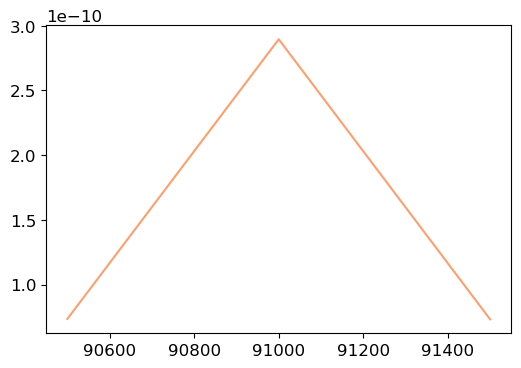

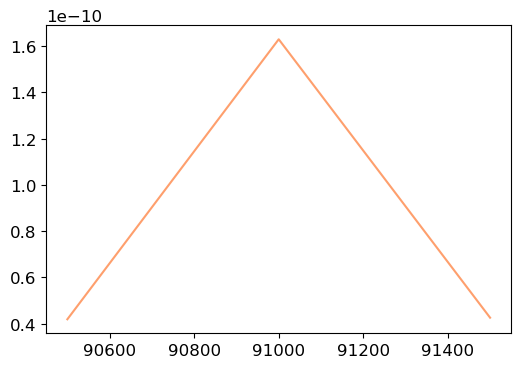

In [154]:
v21 = get_area_driven(ffzb1, ppzb1, (90000, 92000))
v22 = get_area_driven(ffzb2, ppzb2, (90000, 92000))

c_cal_square_1 = get_cal_factor_driven(1, omega01, gamma1, 5, 91000, v21)
c_cal_square_2 = get_cal_factor_driven(1, omega02, gamma2, 5, 91000, v22)

print(c_cal_square_1 / c_cal_square_2)

### Implemented an optimal filter, doesn't work very well

Took some new calibration data, assuming there is one charge.

In [6]:
file_nopulse = r'/Volumes/LaCie/20240723_minus_one_e_data/20240723_nopulse_2e-8mbar/20240723-0001/20240723-0001_1.mat'
dtt0, tt0, nn0 = load_timestreams(file_nopulse, ['D'])

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_35474/476892587.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 ))


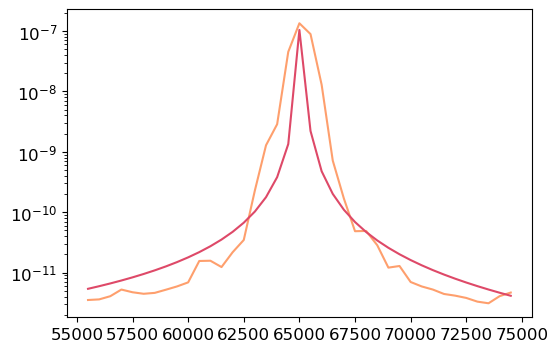

In [7]:
ff0, pp0 = get_psd(dtt0, None, nn0[0], nperseg=10000)
a0, omega0, gamma0 = fit_z_peak(ff0, pp0, log_peak_func, p0=[2e8, 65000*2*np.pi, 100], passband=(55000, 75000))

In [36]:
def impulse_response(tt, omega0, gamma):
    beta = gamma / 2
    return np.exp(-1 * beta * tt) * (1 / np.sqrt(omega0**2 - beta**2)) * np.sin(np.sqrt(omega0**2 - beta**2) * tt)

Construct signal template

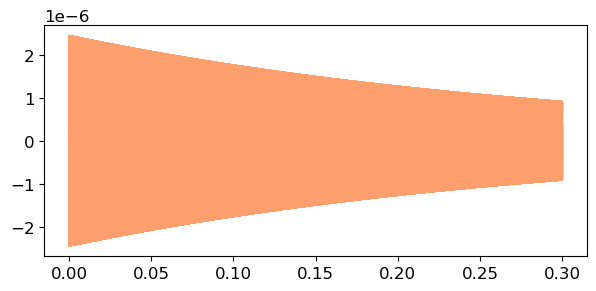

In [37]:
search_window = 0.3
tt_template = np.arange(0, search_window, dtt0)
pulse_template = impulse_response(tt_template, omega0, gamma0)

plt.plot(tt_template, pulse_template)
sk = fft(pulse_template)

Construct noise covariance matrix - estimate it from PSD (would be diagonal here)

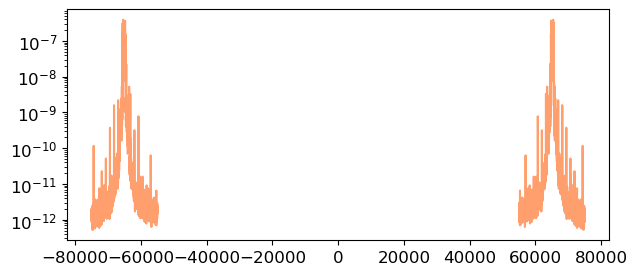

In [55]:
from scipy.signal import welch

ff0, pp0 = welch(nn0[0], fs=np.ceil(1/dtt0), nperseg=tt_template.size, return_onesided=False)

passband = (55000, 75000)
good_idx = np.logical_or(np.logical_and(ff0 > passband[0], ff0 < passband[1]),
                         np.logical_and(ff0 > -1*passband[1], ff0 < -1*passband[0]))
pp0[np.logical_not(good_idx)] = np.inf

plt.plot(ff0, pp0)
plt.yscale('log')

(55000.0, 75000.0)

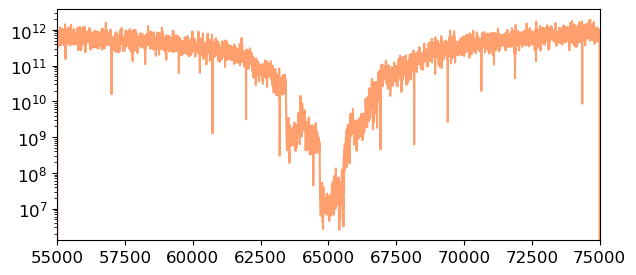

In [95]:
plt.plot(ff0, 1 / pp0)
plt.yscale('log')
plt.xlim(55000, 75000)

In [87]:
def matched_filter(xk, Rk_inv, sk):
    hk = sk * Rk_inv
    return np.dot(xk, np.conjugate(hk))

In [16]:
file_20v = r'/Volumes/LaCie/20240723_minus_one_e_data/20240723_20v_2e-8mbar/20240723-0001/20240723-0001_2.mat'
dtt, tt, nn = load_timestreams(file_20v, ['D', 'G'])

In [30]:
fs = int(np.ceil(1/dtt))
filtered = bandpass_filtered(nn[0], fs, 50000, 80000, 6)

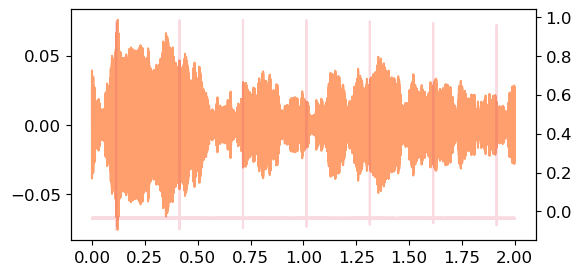

In [31]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(tt, filtered, colors[0])
ax.twinx().plot(tt, nn[1], colors[1], alpha=0.2)

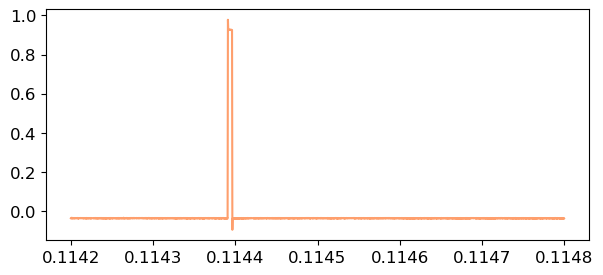

In [78]:
plt.plot(tt[571000:574000], nn[1][571000:574000])

In [80]:
fit_size = nn[0].size - tt_template.size
filter_output = np.empty(3000)

for count, i in enumerate(range(571000, 574000)):
    if (i % 100 == 0): print(i)
    xk = fft(filtered[i:i+tt_template.size])
    filter_output[count] = matched_filter(xk, 1/pp0, sk)
    

571000


/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_34755/184921974.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  filter_output[count] = matched_filter(xk, 1/pp0, sk)


571100
571200
571300
571400
571500
571600
571700
571800
571900
572000
572100
572200
572300
572400
572500
572600
572700
572800
572900
573000
573100
573200
573300
573400
573500
573600
573700
573800
573900


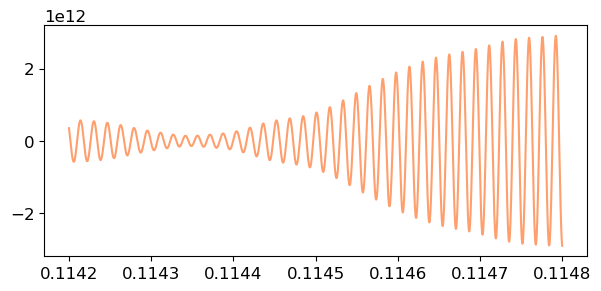

In [84]:
plt.plot(tt[571000:574000], filter_output)

In [86]:
filter_output

array([ 3.51740738e+11,  3.15503802e+11,  2.77403260e+11, ...,
       -2.79377543e+12, -2.85333522e+12, -2.89584715e+12])

### Divide directly by susceptibility and get F(t)

In [4]:
file_20v = r'/Volumes/LaCie/20240723_minus_one_e_data/20240723_20v_2e-8mbar/20240723-0002/20240723-0002_2.mat'
dtt, tt, nn = load_timestreams(file_20v, ['D', 'G'])

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/LaCie/20240723_minus_one_e_data/20240723_20v_2e-8mbar/20240723-0002/20240723-0002_2.mat'

In [ ]:
fs = int(np.ceil(1/dtt))
filtered = bandpass_filtered(nn[0], fs, 50000, 80000, 6)

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(tt, filtered, colors[0])
ax.twinx().plot(tt, nn[1], colors[1], alpha=0.2)

In [63]:
zz = nn[0]
zzk = fft(zz)
freq = fftfreq(zz.size, dtt)
omega = freq * 2 * np.pi

passband = (50000, 75000)
good_idx = np.logical_or(np.logical_and(freq > passband[0], freq < passband[1]),
                         np.logical_and(freq > -1*passband[1], freq < -1*passband[0]))
zzk[np.logical_not(good_idx)] = 0

ffk = zzk / get_susceptibility(omega, omega0, gamma0)
ff = ifft(ffk)

(-100000.0, 100000.0)

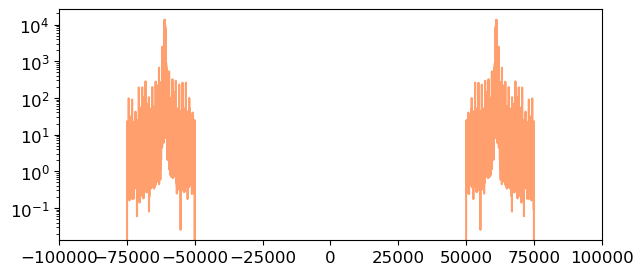

In [64]:
plt.plot(freq, np.abs(zzk))
plt.yscale('log')
plt.xlim(-100000, 100000)

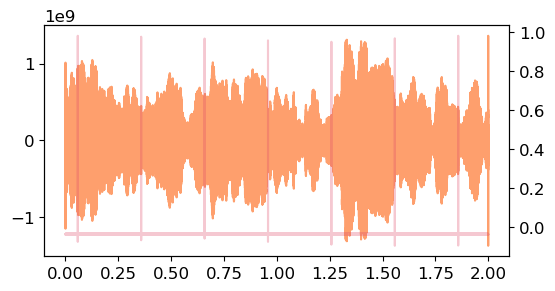

In [67]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(tt[100:-100], ff[100:-100])
ax.twinx().plot(tt[100:-100], nn[1][100:-100], colors[1], alpha=0.3)

(-100000.0, 100000.0)

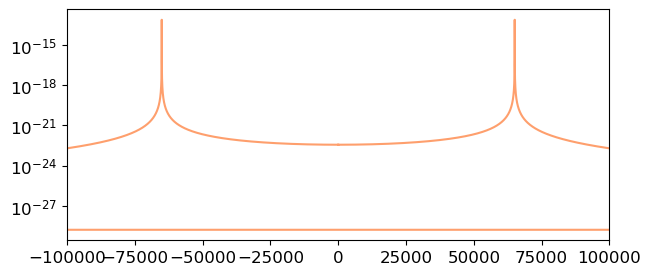

In [84]:
plt.plot(freq, np.abs(get_susceptibility(omega, omega0, gamma0))**2)
plt.yscale('log')
plt.xlim(-100000, 100000)

In [92]:
search_window = int(np.ceil(0.3 / dtt))
filter_output = np.empty(3000)

for count, i in enumerate(range(571000, 574000)):
    if (i % 100 == 0): print(i)

    zz = nn[0][i:i+search_window]
    zzk = fft(zz)
    
    freq = fftfreq(zz.size, dtt)
    omega = freq * 2 * np.pi

    passband = (50000, 75000)
    good_idx = np.logical_or(np.logical_and(freq > passband[0], freq < passband[1]),
                             np.logical_and(freq > -1*passband[1], freq < -1*passband[0]))
    zzk[np.logical_not(good_idx)] = 0
    
    ffk = zzk / get_susceptibility(omega, omega0, gamma0)
    filter_output[count] = np.sum(np.abs(ffk))

571000
571100
571200
571300
571400
571500
571600
571700
571800
571900
572000
572100
572200
572300
572400
572500
572600
572700
572800
572900
573000
573100
573200
573300
573400
573500
573600
573700
573800
573900


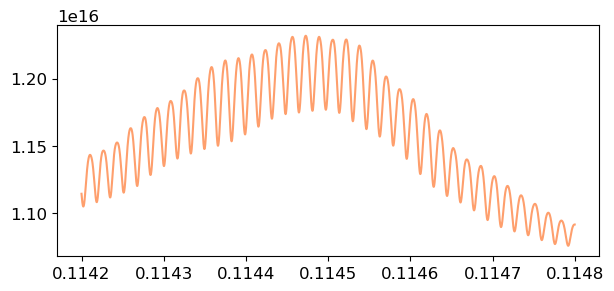

In [93]:
plt.plot(tt[571000:574000], filter_output)

### Downsample data by a factor of 20 to accelerate the calculation.

In [5]:
file_20v = r'/Volumes/LaCie/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0001/20240724-0001_2.mat'
dtt, tt, nn = load_timestreams(file_20v, ['D', 'G'])

fs = int(np.ceil(1/dtt))
filtered = highpass_filtered(nn[0], fs, 20000, 6)

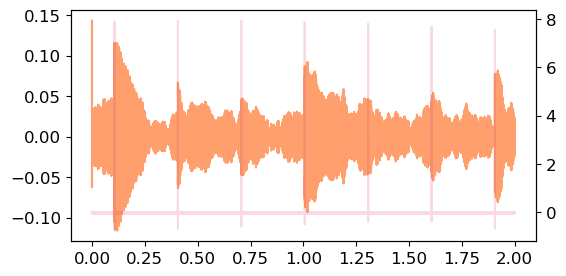

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(tt, filtered, colors[0])
ax.twinx().plot(tt, nn[1], colors[1], alpha=0.2)

In [29]:
from scipy.signal import decimate
zz_down = decimate(nn[0], 20)
dt_down = dtt * 20

In [36]:
import sys, importlib
importlib.reload(sys.modules['pulse_recon'])
from pulse_recon import get_pulse_amp

In [37]:
amp = get_pulse_amp(dt_down, zz_down)

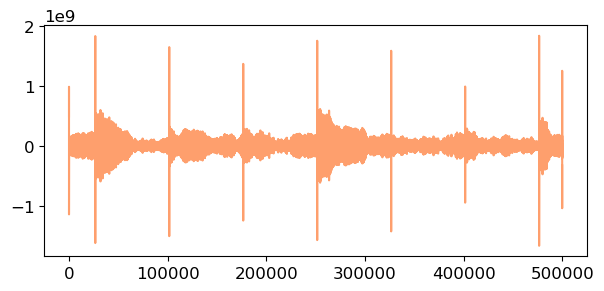

In [38]:
plt.plot(amp)

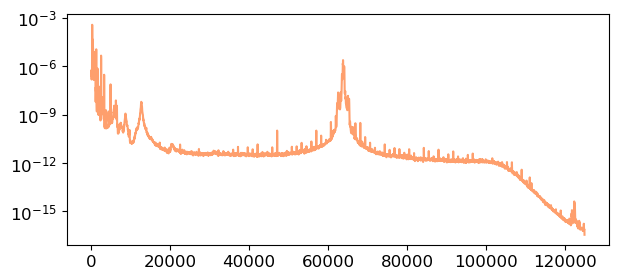

In [8]:
ff, pp= get_psd(dt_down, None, zz_down, nperseg=10000)
plt.plot(ff, pp)
plt.yscale('log')

63811.99759402258 104.86491953760545


/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2889/476892587.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 ))


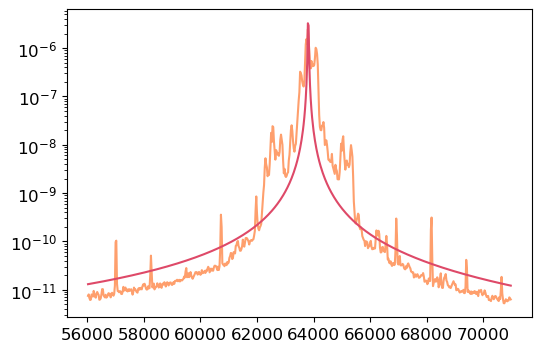

In [9]:
a0, omega0, gamma0 = fit_z_peak(ff, pp, log_peak_func, passband=(56000, 71000))
print(omega0/(2*np.pi), gamma0)

Use STFT to calculate the Fourier transform in each time window.

In [10]:
def get_susceptibility(omega, omega0, gamma):
    chi = 1 / (omega0**2 - omega**2 - 1j*gamma*omega)
    return chi

In [27]:
zzk = fft(nn[0])

ff = fftfreq(nn[0].size, dtt)
omega = ff * 2 * np.pi

chi_omega = get_susceptibility(omega, omega0, gamma0)

passband_recon=(45000, 80000)
good_idx = np.logical_or(np.logical_and(ff > passband_recon[0], ff < passband_recon[1]),
                         np.logical_and(ff > -1*passband_recon[1], ff < -1*passband_recon[0]))
chi_omega[np.logical_not(good_idx)] = np.inf

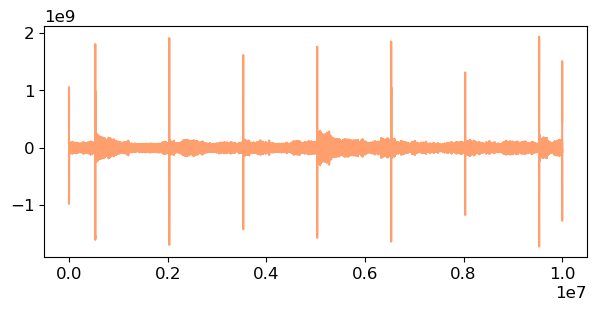

In [28]:
plt.plot(ifft(zzk / chi_omega))

In [93]:
fs = int(np.ceil(1 / dt_down))
window_length = int(np.ceil(0.1 / dt_down))

In [94]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import flattop

w = flattop(window_length, sym=True)
SFT = ShortTimeFFT(w, hop=20, fs=fs, fft_mode='twosided', mfft=None, scale_to='magnitude')

Szz = SFT.stft(zz_down)

In [95]:
ff = fftfreq(window_length, dt_down)
omega = ff * 2 * np.pi

chi_omega = get_susceptibility(omega, omega0, gamma0)

In [96]:
filter_output = np.empty(Szz.T.shape[0])
passband = (50000, 75000)
good_idx = np.logical_or(np.logical_and(ff > passband[0], ff < passband[1]),
                         np.logical_and(ff > -1*passband[1], ff < -1*passband[0]))

for i, sz in enumerate(Szz.T):    
    ffk = sz  / chi_omega
    filter_output[i] = np.sum(np.abs(ffk[good_idx]))

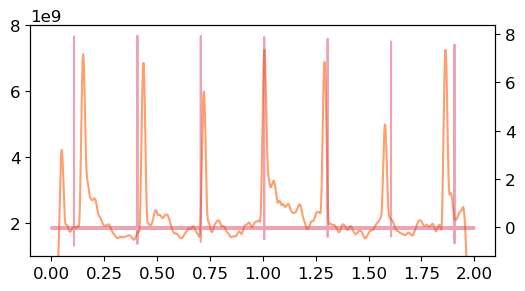

In [97]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.set_ylim(1e9, 8e9)
ax.plot(np.linspace(0, 2, filter_output.size), filter_output)
ax.twinx().plot(tt, nn[1], color=colors[1], alpha=0.5)

In [9]:
aa = np.load('recon_amp_150v.npy')

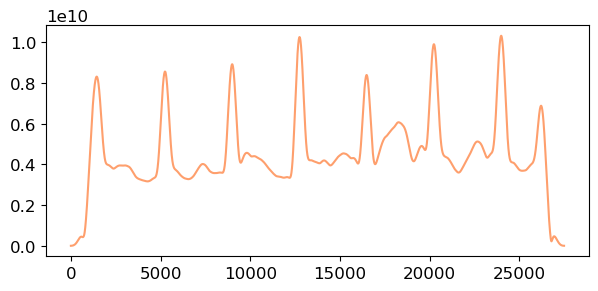

In [11]:
plt.plot(aa[0])

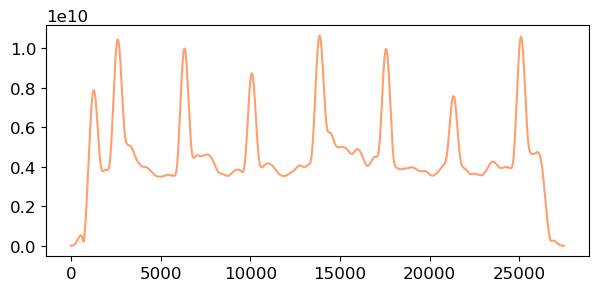

In [12]:
plt.plot(aa[1])